Arjun Joshi
11/10/2024
BrainStation
Deliverable 5: NLP, Advanced Stas & Modelling


##### Assignment Instructions

**NLP Modelling Assignment: Overview**


                        Pipeline & PCA
        
Using a pipeline, combine PCA with a decision tree classifier.
Optimize at least 3 hyperparameters including the maximum tree depth and the minimum number of data points required on each leaf node.
You can use 20 principle components.
The best parameters should be found using 5-fold cross validation.
Contrast the best results here with the logistic regression model and provide any insights that you may draw from the results.

                        Confusion Matrix
*[jump to code cell 2](#cell2)

For your best performing model, conduct a more in-depth evaluation by analyzing the confusion matrix and commenting on the model errors and metrics such as precision and recall.
Requirements
Please submit your Jupyter notebook which should include commented code and extensive markdown cells explaining your process and insights. Make sure to add a table of contents, introduction, proper section headers and a conclusion section. Your communication in the markdown cells and the code cell outputs should allow anyone to understand your process and findings without the need to read the code.

# Table of Contents

[Part 1: Data Preprocessing, EDA](Part111)

[Part 1: Data Preprocessing, EDA](Part1)

[Part 2: Text Preprocessing](Part2)

[Part 3:TT_Split Tokenize, LogReg Fitting](Part3)

[Part 4: Pipeline & PCA](Part4)

[Part 5: Confusion Matrix](Part2)

[Index:Data Dictionary](Index)

## Getting Ready: Load, Format, Custom Functions, Basic Cleaning

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from warnings import filterwarnings
from sklearn.model_selection import train_test_split
from scipy import stats

filterwarnings(action='ignore')
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

Pipeline(steps=[('normalise', StandardScaler()),
                ('dimred', PCA(n_components=7)),
                ('model',
                 DecisionTreeClassifier(max_depth=4, min_samples_leaf=2))])

### Custom Functions

Commentary:
- I developed these along the way after having perform specific checks repeatedly.
- Being able to correct data types, get information in a simplified way certainly helped but in a realistic setting "could" impact computing costs, rendering these unsuable.
- Custom Tokenizer was taken directly from the NLP notes. Contrary to my thoughts, the CountVectorizer might not cover enough and a custom tokenizer might enable that.
- In terms of overall assignment efficiency, these may not have saved a large amount of time though it was convenient.



In [118]:
################################################## fx lazy-info
def lazy_info(df):
    print(f'SHAPE:{df.shape},\n\n')
    df.info()
    print(df.describe())
    print(df.value_counts())
    
    df.head(2)

################################################## fx auto heatmap from df

def get_heatmap(func_df,drop_col=[]):
    # Correlations for independent variables
    func_df.drop(columns=drop_col,inplace=True)
    test=numeric_check(func_df)
    try:
        indcorr=func_df.corr()
    except ValueError:
        print('********\n********\n********\n DF has  still has format issues. Drop unsupported columns or re-check df\n********\n********\n********\n')
        return()
    #Heatmap
    mask=np.triu(indcorr)
    plt.figure(figsize=(20,15))
    sns.heatmap(indcorr.round(2), vmax=1,vmin=-1,center=0,cmap='icefire',mask=mask, annot=True)
    plt.show

################################################## fx shorter df numeric checl
def numeric_check(df):
    # quick way to check
    # dfs are having formatting issues in the code....
    # formats them to appropriate dtype
    
    # Input
    #        df: The pandas DataFrame to format.

    # Output:
    #        formatted df
    
    bad_col=[]
    nas=[]
    tf_type=True
    tf_na=True
    for col in df.columns:
        if df[col].dtype in (object,str):
            bad_col.append(col)
            tf=False
            continue
        if df[col].isna().sum()>0:
            na.append(col)
            tf_na=False
    if bad_col: 
        print(f' The following columns have values that are not numeric or nulls: {bad_col}')
    else:
        return(tf_na,tf_type,bad_col)

################################################## 
# Function to reassign dtypes because type mismatches are creating errors

def correct_df_dtype(df):
    # infers appropriate data types to a DataFrame.
    # dfs are having formatting issues in the code....
    # formats them to appropriate dtype
    
    # Input
    #        df: The pandas DataFrame to format.

    # Output:
    #        type formatted df
    
    for col in df.columns:

        if pd.api.types.is_numeric_dtype(df[col]): #numeric
            if df[col].dtype == 'float64': #ints
                all_integer = True
                for value in df[col].dropna():
                    if not value.is_integer():
                        all_integer = False
                        break
                if all_integer:
                    df[col] = df[col].astype('int64')
        
        elif pd.api.types.is_string_dtype(df[col]):
            try:
                df[col] = pd.to_datetime(df[col]) #DateTime
            except ValueError:
                pass  # If conversion fails, leave as string

    return df
    
################################################## custom tokenizer, format taken from NLP Lecture

def custom_tokenizer(text):
    # Taken from NLP Lecture, ight not be used
    # Brought in because vectorizer not formatting as needed
    # Will customize as needed
    
    # lower text
    # handled by vectorizer
    text = text.lower()

    # remove special characters
    text = re.sub(f"[{forbidden_char}]", "", text)

    # split into words as tokens
    tokens = text.split()

    # filter stopwords
    tokens = [tok for tok in tokens if tok not in ENGLISH_STOP_WORDS]

    return tokens

#### Data Overview, Loading

In [135]:
hotel=pd.read_csv('data/Hotel_Reviews.csv')

In [136]:
hotel.describe()

,Unnamed: 0,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Days_Since_Review,Latitude,...,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Leisure_Trip,Nights_Stayed
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,...,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,257868.500000,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,0.570006,354.441932,49.432419,...,0.068711,0.365121,0.110936,0.116627,0.508594,0.072143,0.116199,0.075502,0.810059,2.362122
std,148880.880902,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,0.495075,208.928124,3.460237,...,0.252963,0.481465,0.314053,0.320976,0.499927,0.258725,0.320463,0.264199,0.392255,1.646808
min,0.000000,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,0.000000,41.328376,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,128934.250000,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,0.000000,175.000000,48.214066,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,257868.500000,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,1.000000,353.000000,51.499981,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000
75%,386802.750000,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,1.000000,527.000000,51.516288,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,3.000000
max,515737.000000,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,1.000000,730.000000,52.400181,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,31.000000


In [137]:
# First column provides no insight given without a label. It appears to be an old index.
# both scenarios warrant dropping it

hotel.drop(columns=hotel.columns[0],inplace=True)

In [138]:
# Re-ordering columns of df to make it more readable

hotel=hotel[['Reviewer_Score',
 'Nights_Stayed',
 'Positive_Review',
 'Negative_Review',
 'Additional_Number_of_Scoring',
 'Average_Score',
 'Leisure_Trip', 
 'Days_Since_Review',
 'Total_Number_of_Reviews', 
 'Total_Number_of_Reviews_Reviewer_Has_Given',
 'Review_Total_Negative_Word_Counts', 
 'Review_Total_Positive_Word_Counts',
 'Latitude',
 'Longitude',
 'Day',
 'Month',
 'Year',
 'Reviewer_Nationality_Australia',
 'Reviewer_Nationality_Ireland',
 'Reviewer_Nationality_UAE',
 'Reviewer_Nationality_UK',
 'Reviewer_Nationality_USA',
 'Reviewer_Nationality_Other',
 'Hotel_Address_Amsterdam',
 'Hotel_Address_Barcelona',
 'Hotel_Address_London', 
 'Hotel_Address_Milan', 
 'Hotel_Address_Paris',
 'Hotel_Address_Vienna']]


In [139]:
# No null values "at face value"
# When I tried to run np.isnan it crashed my kernel repeatedly.
hotel.isna().sum().sum()

# numeric check also returns the name of columns that are non-numeric
numeric_check(hotel)
numeric_check(hotel.drop(columns=(['Positive_Review', 'Negative_Review'])))

 The following columns have values that are not numeric or nulls: ['Positive_Review', 'Negative_Review']


(True, True, [])

In [140]:
# After removing old index, we can actually take a look a possible duplicates. The old index was a hindrance and it was shown
# in the earlier loop that it matches the index.

hotel.duplicated().value_counts()

False    515199
True        539
Name: count, dtype: int64

In [141]:
# Drop the duplicates, keep one copy. Index irrelevant presently, dropping first.

print(hotel.drop_duplicates(keep='first').shape)
hotel.drop_duplicates(keep='first',inplace=True)
print(hotel.shape)

(515199, 29)
(515199, 29)


In [142]:
print('nulls: ',hotel.isna().sum().sum())
print('\nDuplicated: \n',hotel.duplicated().value_counts())

nulls:  0

Duplicated: 
 False    515199
Name: count, dtype: int64


In [143]:
hotel[hotel=='NaN'].sum().sum()

0.0

In [128]:
hotel.Reviewer_Score.value_counts()

Reviewer_Score
1    293715
0    221484
Name: count, dtype: int64

## Question 1: Basic EDA, Basic Cleaning

<a class="anchor" name="Part1"></a>

Overview:

Cleaning of the data wasn't extensive. Duplicates and nulls were removed; however, this does not include cleaning of the text. This will be done during the pre-processing stage for tokenization. Getting basic information will give an overall picture but will be useful during feature reduction. Correlation values should be helpful in assessing colinearity; however, basic investigation into collinnearity will be limited as that will also be addressed through PCA during the modelling process; it does remain to be seen whether it's appropriate to consolidate the dummy variables to explain more of the cumulative variance - but that material will be saved for later in the analysis.

This is a preliminary examination of base metrics.
Basic column statistics are detailed immediately below. There are a total of 30 columns in the base table.



Notes:
- The extra index from the raw imported .csv was dropped at the start of the notebook
- While there are no duplicates now, it seems that 'Additional_Number_of_Scoring' and 'Average Score' are aggregated at some higher level, though it's not clear what. Unfortunately, trying to do so would result in a loss of information, so that's not going to be done. The nature of the value - sum or average, needs to be determined.

In [129]:
lazy_info(hotel)

SHAPE:(515199, 29),


<class 'pandas.core.frame.DataFrame'>
Index: 515199 entries, 0 to 515737
Data columns (total 29 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Reviewer_Score                              515199 non-null  int64  
 1   Nights_Stayed                               515199 non-null  int64  
 2   Positive_Review                             515199 non-null  object 
 3   Negative_Review                             515199 non-null  object 
 4   Additional_Number_of_Scoring                515199 non-null  int64  
 5   Average_Score                               515199 non-null  float64
 6   Leisure_Trip                                515199 non-null  int64  
 7   Days_Since_Review                           515199 non-null  int64  
 8   Total_Number_of_Reviews                     515199 non-null  int64  
 9   Total_Number_of_Reviews_Reviewer_Has_Given  515199 no

In [130]:
hotel.head(5)

,Reviewer_Score,Nights_Stayed,Positive_Review,Negative_Review,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,...,Reviewer_Nationality_UAE,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna
0,0,6,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,194,7.7,1,0,1403,7,...,0,0,0,1,1,0,0,0,0,0
1,0,4,No real complaints the hotel was great great ...,No Negative,194,7.7,1,0,1403,7,...,0,0,0,0,1,0,0,0,0,0
2,0,3,Location was good and staff were ok It is cut...,Rooms are nice but for elderly a bit difficul...,194,7.7,1,3,1403,9,...,0,0,0,0,1,0,0,0,0,0
3,0,3,Great location in nice surroundings the bar a...,My room was dirty and I was afraid to walk ba...,194,7.7,1,3,1403,1,...,0,1,0,0,1,0,0,0,0,0
4,0,2,Amazing location and building Romantic setting,You When I booked with your company on line y...,194,7.7,1,10,1403,3,...,0,0,0,1,1,0,0,0,0,0


In [131]:
len(hotel.Additional_Number_of_Scoring.unique())

480

In [132]:
len(pd.concat([hotel.Additional_Number_of_Scoring,hotel.Total_Number_of_Reviews]).unique())

1360

In [133]:
# Take a look at a duplicate line
hotel.loc[hotel.Year.eq(2015) & hotel.Day.eq(4) & hotel.Month.eq(8) & hotel.Reviewer_Nationality_UK.eq(1) & hotel.Total_Number_of_Reviews.eq(2515)]	

,Reviewer_Score,Nights_Stayed,Positive_Review,Negative_Review,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,...,Reviewer_Nationality_UAE,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna
180112,1,1,Very convenient for Gare de Montparnasse,Need better directions from Metro,228,7.9,1,730,2515,9,...,0,1,0,0,0,0,0,0,1,0


In [ ]:
hotel.drop(columns=['Negative_Reviews','Positive_Reviews'],inplace=True)

In [ ]:
hotel.info()

Cleaning of the text data will be done in the preprocessing stage.

In [ ]:
# General details overview
fig, ax1 = plt.subplots(layout='tight',figsize=(10,10))
plt.box(on=None)
plt.axis('off')

plt.subplot(2,2,1)
ax1=plt.gca()
hotel.Reviewer_Score.value_counts().plot(kind='bar',xlabel='Reviewer Score',
                                         ylabel='Number of Reviews',
                                         title=f' Reviewr Scores. Success Rate: {round(hotel.Reviewer_Score.sum()*100/hotel.Reviewer_Score.count(),2)}%',fontsize='xx-small',ax=ax1)
ax1.set_ylabel('Number of Reviews')


plt.subplot(2,2,2)
ax2=plt.gca()
sns.histplot(hotel[hotel.Reviewer_Score==0].Average_Score,bins=30, alpha=0.5,color='blue',label='Negative Reviewer Score')
sns.histplot(hotel[hotel.Reviewer_Score==1].Average_Score, bins=30,alpha=0.5,color='orange',label='Positive Reviewer Score')
ax2.legend()
ax2.set_ylabel('Number of Reviews')

plt.subplot(2,2,3)
ax3=plt.gca()
#sns.barplot(hotel[hotel.columns[16:23]].sum(),ax=ax3)
hotel[hotel.columns[14:20]].sum().plot(kind='bar')
ax3.tick_params(axis='x', rotation=60)
ax3.set_title('Reviewers by Nationality')
ax3.set_xlabel('Nationality')
ax3.set_ylabel('Number of Reviews')


plt.subplot(2,2,4)
ax4=plt.gca()

sns.barplot(hotel[hotel.columns[20:26]].sum(),ax=ax4)
ax4.tick_params(axis='x', rotation=90)
ax4.set_title('Reviewers by Hotel Location')
ax4.set_xlabel('Hotel Location')
ax4.set_ylabel('Number of Reviews')
ax4.tick_params(axis='x', rotation=60)
plt.suptitle('(Fig.1.1): Basic Overview Data: Distribution and Counts')
plt.show()

Our target feature and objective is to determine the outcome of a reviewer's score based on the data presesnted and, in particular, the language provided in the review columns. Basic EDA will give us some preliminary insight.

A (top left) - A positive results rate from a reviewer of 57%.
B (top right)- While scores from negative reviews are generally less than positive reviews, they they're still somewhat consistent with one another.
C/ D (bot)- This a look at the dummy columns in the data. They are strongly weight towards one or two categories (US/USA Nationality, London location)

This is a pretty general breakdown. There's less of a disparity count values of positive and negative reviewer scores. It was surprising that the average score of the review scorers, when designated a negative review, was not that much lower than the review_score=1 class.

This may have to do with the way average score is represented in the data, as those values aren't homogenous. Having a set average review score in a sample group that's unevenly distributed along another class would skew the data when trying to assess the average score of each class.

Nationality and Hotel Location of reviews is represented in the data through dummy variables. The distribution of the counts are not consistent across all categories. Nationality is has 2 strong sample groups whereas hotel location is strongly weighted towards London.

In [ ]:
# Calculating Proportion of reviewer scores
hotel.Reviewer_Score.value_counts().loc[1,]/hotel.Reviewer_Score.value_counts().sum()

#### Visualizations

In [ ]:
hotel.Total_Number_of_Reviews_Reviewer_Has_Given.describe()	

In [ ]:
hotel[hotel.Reviewer_Score==1].Average_Score.describe()

In [ ]:
plt.subplots(1,1)


sns.histplot(-hotel.Review_Total_Negative_Word_Counts, label='Total Negative Word Counts, Left', bins=50)
sns.histplot(hotel.Review_Total_Positive_Word_Counts,label='Total Positive Word Counts, Right',bins=50)
plt.yscale('log')
plt.ylabel('Review counts, (log scale)')
plt.xlabel('Word count in review. Negative Reviews with negative values')
plt.legend()
plt.title('Mirror Distribution of Negative and Positive Word Counts')
#Perhaps unnecessary but I thuoght it might be a good way to visualize any difference
#Between the two. Except 



Taking a look at distribution of word counts in the reviews. This chart helps visualize the difference in review counts between the two categories of the target feature. Both sides seem to cap at 400 words - which may be a limitation placed by the hotel.

In [ ]:
# positive word count per negative review
print('Number of Words in Negative Reviews: ',hotel.Review_Total_Negative_Word_Counts.sum()/(hotel[hotel.Reviewer_Score==0].Reviewer_Score.count()))
print('Number of Words in Positive Reviews: ',hotel.Review_Total_Positive_Word_Counts.sum()/(hotel[hotel.Reviewer_Score==1].Reviewer_Score.count()))
# negative word count per negative review

In [ ]:
print((hotel[hotel.Reviewer_Score==1].Reviewer_Score.count()))
print((hotel[hotel.Reviewer_Score==0].Reviewer_Score.count()))

## Question 2: Text Pre-Processing <a class="anchor" name="Part2"></a>
TT-Split Now <br>
Check CountVectorizer doc. about tokenization procedures - what might it be skipping that's covered below?
- lowercase must be specified
- special characters and punctuation auto
- split auto.
- *****StopWords

<div class="alert alert-block alert-warning">
<b>QUESTION 2 TEXT:</b><p style="color:black;"><b></b><br>
Split the data into train and test sets and transform the positive and negative review columns using a CountVectorizer. Consider the following: <br>
- What tokenizer and text cleaning steps do you include?<br>
- Using the vectorizer, maximize the number of features at 500 and make sure that tokens used <10 times are dropped from the vocabulary.
    
<p style="color:red;">This process may be done on the positive and negative review columns separately and then the resulting arrays merged with the original numeric features to form the final train and test data frames ready for modelling. In your column names, make sure you mark which words are coming from the positive vs negative reviews (you can use a prefix such as pos_ and neg_).
</b></p></div>

### Text Review

In [ ]:
hotel.info()

In [ ]:
print('Number of Words in Negative Reviews: ',hotel.Review_Total_Negative_Word_Counts.sum()/(hotel[hotel.Reviewer_Score==0].Reviewer_Score.count()))
print('Number of Words in Positive Reviews: ',hotel.Review_Total_Positive_Word_Counts.sum()/(hotel[hotel.Reviewer_Score==1].Reviewer_Score.count()))

In [ ]:
hotel.Review_Total_Negative_Word_Counts.describe()
hotel.iloc[1,3]

In [ ]:
x=len(hotel.index)*.9
x=round(x,0)
#hotel.Review_Total_Negative_Word_Counts.iloc[hotel.Review_Total_Negative_Word_Counts.index.max*.9]

In [ ]:
int(x)

In [ ]:
hotel.Review_Total_Negative_Word_Counts.sort_values(ascending=True).iloc[int(x)]

 ##### _**Histograms of Positive and Negative Word Counts**_

In [ ]:
#  >90 % Positive Review word counts covered by values of 50 or less
plt.figure(figsize=(3,3))
print(hotel.Review_Total_Negative_Word_Counts.describe())
hotel[hotel.Review_Total_Negative_Word_Counts<50].Review_Total_Negative_Word_Counts.hist()
plt.title('Distribution of Negative Word counts \n Average of 18.5 words per review.')
plt.xlabel('Word Counts')
plt.ylabel('Number of Reviews')

In [ ]:
#  Over of 90 % Positive Review word counts covered by values of 50 or less
plt.figure(figsize=(3,3))
print(hotel.Review_Total_Positive_Word_Counts.describe())
hotel[hotel.Review_Total_Positive_Word_Counts<50].Review_Total_Positive_Word_Counts.hist()

plt.title('Distribution of Positive Word counts \n Average of 17.7 words per review.')
plt.xlabel('Word Counts')
plt.ylabel('Number of Reviews')

2 quick illustrations of patterns of word counts between positive and negative reviews. This plot makes clearer the difference in volume of shorter reviews.

In [ ]:
#### keeping a checkpoint
#hotel_copy=hotel.copy()
#hotel=hotel_copy.copy()

In [ ]:
#Special characters are handled by Vectorizer, not needed here in custom tokenizer
#re.sub(f"[{forbidden_char}]",'','testing2323.')

In [ ]:
print('Positive Review: ',(hotel[hotel.Reviewer_Score==1].Reviewer_Score.count()))
print('Negative Review: ',(hotel[hotel.Reviewer_Score==0].Reviewer_Score.count()))
print('%Difference: ',round(((hotel[hotel.Reviewer_Score==1].Reviewer_Score.count())/(hotel[hotel.Reviewer_Score==0].Reviewer_Score.count())-1)*100,2),'%')

Shown above in a normalized visual, there are 32.61% more positive reviews.

### Cleaning the Text

In [ ]:
hotel.info()

A trend was noticed in the data that there are cells for the text data that are labeled as "no positive" or "no negative.
These were found to be a significant number. They do not add any new information and only serve to cause error in a sentiment analysis by
presenting contrasting terminology ('positive' in the negative column, for ex.) It has to be addressed beforehand or during tokenization.

In [ ]:
hotel.info()

In [ ]:
# For Positive Review: Removing what should be blank cells
print(hotel[hotel.Negative_Review=='No Negative'].Negative_Review.count())
print(hotel[hotel.Negative_Review=='No Positive'].Negative_Review.count())
print(hotel[hotel.Positive_Review=='No Negative'].Positive_Review.count())
print(hotel[hotel.Positive_Review=='No Positive'].Positive_Review.count())

In [ ]:
hotel['Negative_Review']=hotel['Negative_Review'].replace('No Negative','')

# Replaced and then checked with the hotel.info() above.
# DF datatype was getting set to object in all columns if done any other way

---

---

### Train-Test Splits, Tokenization, N-Grams

A quick review of the instructions: we are to take the positive and negative review columns and process them into tokens of words or phrases. Given they are in separate columns, they will need to be processed separately but merged/contatenated at the end of the process. At the same time, we will set up the tokenization process. There ist he option to use a custom tokenizer, the CountVectorizer which handles some functions automatically, or both.

There are 2 sets of data to start. All data sets must be split into Testing and Training Data. More data may be split from the training set for a validation set. These must occur before the data is split otherwise to ensure that the splits are consistent.

For the upcoming logistic regression, we will include the validation set. An analysis of the positive and negative sentiments will be performed after tokenization. 

The original data shape is below, confirmation of the splits and consistency will be maintained.

In [ ]:
hotel.shape
# 515199 rows, 28 total columns. These will be reduced to 2.

In [ ]:
hotel.info()

In [ ]:
# Assign independent feature(s) X, and target, dependent feature, y.
# Subdividing into Pos/Neg groups occurs after the 2 Train-Test Splits
# Dataset shape
X=hotel.drop(columns='Reviewer_Score')
y=hotel.Reviewer_Score
#Using a 20%:10% 
X1_train,X_test,y1_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, VX_test, y_train, Vy_test = train_test_split(X1_train,y1_train, test_size=0.1, random_state=42)

In [ ]:
#Confirming split
print(f' XTrain1 {X1_train.shape}')
print(f' Xtest {X_test.shape}')
print(f' y1train{y1_train.shape}')
print(f' ytest{y_test.shape}')

#Shapes are consistent

In [ ]:
# Next split for validation set.
X_train, VX_test, y_train, Vy_test = train_test_split(X1_train,y1_train, test_size=0.1, random_state=42)

First we are splitting the data into train and test data.
Then we are doing an additional split for validation data.

There are 3 sets of data:<br>
- X_train, Y_train (72%)
- X_test,Y_test  (20%)
- VX_test,Vy_test (8%)

In [ ]:
# Shapes are consistent
print(f' XTrain {X_train.shape}')
print(f' Xtest {X_test.shape}')
print(f' VXtest{VX_test.shape}')
print(f' ytrain{y_train.shape}')
print(f' ytest{y_test.shape}')
print(f' Vytest{Vy_test.shape}')


#consistent - X/y Train, X/y Test, VX/Vy Test

In [ ]:
print(f' XTrain {X_train.isna().sum().sum()}')
print(f' Xtest {X_test.isna().sum().sum()}')
print(f' ytrain{y_train.isna().sum().sum()}')
print(f' ytest{y_test.isna().sum().sum()}')
# Double checking for nulls

In [ ]:
X_train.info()

In [ ]:
X_test.info()

In [ ]:
VX_test.info()

In [ ]:
pos_X_train=X_train.Positive_Review
pos_X_test=X_test.Positive_Review
pos_VX_test=VX_test.Positive_Review

In [ ]:
neg_X_train=X_train.Negative_Review
neg_X_test=X_test.Negative_Review
neg_VX_test=VX_test.Negative_Review

**We now have 6 sets of data X_train, x_test, vx_test - positive and negative review score**

### Part 2: Text Preprocessing, Text Cleaning, Tokens, Vectorizer

In [ ]:
# There are data rows were Positive Reviews are actually blank but entered (by whomsoever created the csv) as 'No Positive'
# A decision needs to be made on how to handle them - and before the train test split
hotel[hotel.Positive_Review.str.contains('Positive') & hotel.Reviewer_Score==1].head()

In [ ]:
print(list(ENGLISH_STOP_WORDS)[:10])

In [ ]:
# Create Vectorizers for both positive and negative sets of data
# There are issues in both columns of 'No Positive' or 'No Negative'


#my_stop_words=['english','No Positive','No Negative','no negative','no positive']
# I've read that using english might not be as good? 

pos_vectorizer    = CountVectorizer(max_features=500,
                                    min_df=10,lowercase=True,
                                    stop_words="english",
                                    ngram_range=(1,5))
neg_vectorizer    = CountVectorizer(max_features=500,
                                    min_df=10,lowercase=True,
                                    stop_words="english",
                                    ngram_range=(1,5)
                                   )

## The _test_ data will not be involved in fitting

# Positive Train/Test
pos_X_train_xform = pos_vectorizer.fit_transform(pos_X_train) #ptr=t(xtr.posrev)
pos_X_test_xform  = pos_vectorizer.transform(pos_X_test)
pos_VX_test_xform = pos_vectorizer.transform(pos_VX_test)

# Negative Train/Test
neg_X_train_xform = neg_vectorizer.fit_transform(neg_X_train)
neg_X_test_xform  = neg_vectorizer.transform(neg_X_test)
neg_VX_test_xform = neg_vectorizer.transform(neg_VX_test)

In [ ]:
# Train= fit/transformed
pos_X_train_xform

In [ ]:
# Test= transformed (only)
pos_X_test_xform

In [ ]:
pos_VX_test_xform

In [ ]:
#create densematrix
pos_X_train_dmatrix = pos_X_train_xform.toarray()
pos_X_test_dmatrix  = pos_X_test_xform.toarray()
pos_VX_test_dmatrix = pos_VX_test_xform.toarray()

In [ ]:
# sparse matrices
## to dense arrays
neg_X_train_dmatrix = neg_X_train_xform.toarray()
neg_X_test_dmatrix  = neg_X_test_xform.toarray()
neg_VX_test_dmatrix = neg_VX_test_xform.toarray()

In [ ]:
# Add prefixes to column names
positive_cols = ['pos_' + col for col in pos_vectorizer.get_feature_names_out()]
negative_cols = ['neg_' + col for col in neg_vectorizer.get_feature_names_out()]

# Create final training and testing dataframes
X_train = pd.concat([pd.DataFrame(pos_X_train_dmatrix, columns=positive_cols), pd.DataFrame(neg_X_train_dmatrix, columns=negative_cols)], axis=1)
X_test = pd.concat([pd.DataFrame(pos_X_test_dmatrix, columns=positive_cols), pd.DataFrame(neg_X_test_dmatrix, columns=negative_cols)], axis=1)
VX_test = pd.concat([pd.DataFrame(pos_VX_test_dmatrix, columns=positive_cols), pd.DataFrame(neg_VX_test_dmatrix, columns=negative_cols)], axis=1)

## Question 3. Modelling: Logistic. <a class="anchor" name="Part3"></a>

Fit a logistic regression model on the data and analyze the test and train accuracy. <br>
Find the top 20 words from the positive reviews that are most predictive of a positive sentiment (Reviewer_Score = 1).<br>
Similarly, find the top 20 words from the negative reviews that are most predictive of a negative sentiment (Reviewer_Score = 0).<br> What actionable insights can you draw from these?

#### Checking Old Data, Fitting Model

In [ ]:
X_test.info()

(Editing Note: There have been n-number of times that the program keeps freezing up here and then suddenly converting values to NaNs which then break the routine, forcing a re-run which was...problematic and one of the reasons this assignment is coming late.)

Went back and tweaked the Vectorizer to account for ngrams of 5 - which should mean a drop in "trouble" as the top positive predictor.

### Scaler

In [ ]:
## Now, data is split into Test/Train/Validation and recombined from pos and neg columns into 1 - containing the 
scaler = StandardScaler()

scaler = scaler.fit(X_train)  # fit our scaler to X_train
X_train_ss = scaler.transform(X_train)
X_test_ss = scaler.transform(X_test)
VX_test_ss=scaler.transform(VX_test)
X_train_ss_df = pd.DataFrame(X_train_ss, columns=X_train.columns)

All of the test sets have now been scaled via Standard Scaler. The scaler was trained with the X_train training data. The test and validation data sets were then transformed <br><br>

Now, we're goign to fit the regression models and test them.
These are going to be run without any hyperparameterization for the sake of exercise 3 but can be done with the loop below.

In [ ]:
# Create a scorecard to keep track of accuracy scores
scorecard=pd.DataFrame(columns=['model','scaler','train','test','group','C','penalty','solver'])

In [ ]:
X_train.head(3)

In [ ]:
# Models available:
X_train
X_test
VX_test

X_train_ss
X_test_ss
VX_test_ss

In [ ]:
#Establish a scorecard to test models against 

## Templates
#scorecard_valid=pd.DataFrame(columns=['TypeRegression','Scaler','Penalty','C','Solver','TrainScore','ValidationScore'])
#  scorecard.loc[scorecard.shape[0],:]=['Logistic','Unscaled',train_score, valid_score,test_score]
scorecard=pd.DataFrame(columns=['TypeRegression','Scaler','Penalty','C','Solver','TrainScore','ValidationScore','TestScore'])
#  scorecard.loc[scorecard.shape[0],:]=['Logistic','Unscaled',train_score, valid_score,test_score]

### Log. Regression Models.

In [ ]:
scorecard

In [ ]:
scorecard_valid

In [ ]:
# fitting unscaled log model
log_reg=LogisticRegression()
log_reg.fit(X_train,y_train)

In [ ]:
# fitting scaled log model
log_reg_ss=LogisticRegression()
log_reg_ss.fit(X_train_ss,y_train)

In [ ]:
### UNSCALED TESTING

train_score=log_reg.score(X_train,y_train)
valid_score=log_reg.score(VX_test,Vy_test)
test_score=log_reg.score(X_test,y_test)

print(f'Train score: {log_reg.score(X_train,y_train)}')
print(f'Train score: {log_reg.score(VX_test,Vy_test)}')
print(f'Train score: {log_reg.score(X_test,y_test)}')

#scorecard_valid.loc[scorecard.shape[0],:]=['Logistic','Unscaled',train_score, valid_score,test_score]
scorecard.loc[scorecard.shape[0],:]=['Logistic','Unscaled','default(l2)',1.0 ,'lbfgs',train_score,valid_score,test_score]

In [ ]:
scorecard

In [ ]:
#### SCALED TESTING
train_score_ss=log_reg.score(X_train_ss ,y_train)
test_score_ss=log_reg.score(X_test_ss   ,y_test)
valid_score_ss=log_reg.score(VX_test_ss  ,Vy_test)
print(f'Train score: {log_reg.score(X_train_ss,y_train)}')
print(f'Train score: {log_reg.score(X_test_ss,y_test)}')
print(f'Test score: {log_reg.score(VX_test_ss,Vy_test)}')
scorecard.loc[scorecard.shape[0],:]=['Logistic','Scaled','default(l2)',1.0,'lbfgs',train_score_ss,test_score_ss,valid_score_ss]

In [ ]:
scorecard.loc[scorecard.shape[0],:]=['Logistic','Standard',pos_train_score,pos_test_score,'pos']

In [ ]:
scorecard.loc[scorecard.shape[0],:]=['Logistic','Standard',neg_train_score,neg_test_score,'neg']

In [ ]:
scorecard.loc[scorecard.shape[0],:]=['Logistic','none',train_score,test_score,'comb']

C-parameter loop:Hyperparameterization 

In [ ]:
#C_values = [0.001, 0.01, 0.1, 1, 10, 100]
#Create a loop to test different C values
#for C1 in C_values:
#    #fit
#    X_log_reg_C = LogisticRegression(max_iter=500,C=C1,penalty='l1',solver='saga')
#    X_log_reg_C.fit(X_train_ss, y_train)
#    # Evaluate the model on the test set
#    train_score= X_log_reg_C.score(X_train_ss, y_train)
#    test_score = X_log_reg_C.score(X_test_ss, y_test)
#    scorecard.loc[scorecard.shape[0],:]=['Logistic','Standard',X_pos_train_score,X_test_score,'X',C,'l2','saga']


Given question 3 does not specify anything about hyperparameters, I'll save that for later if there's time.

2 Logistic models were fitted with 3 sets of data - 1 train, 1 validation, 1 test. Although the validation set wasn't specified for question 3, I ran all three during the first evaluation of the models.  The initial results are listed below. Both the scaled and unscaled models performed at similar levels, with the unscaled model performing marginally better - about 1.5%.

In [ ]:
scorecard

### Coefficients

In [ ]:
## scaled
# 
X_train_words_ss=pd.Series(log_reg_ss.coef_[0],index=X_train.columns).sort_values(ascending=False)
print(X_train_words_ss[:3])

## unscaled

X_train_words=pd.Series(log_reg.coef_[0],index=X_train.columns).sort_values(ascending=False)
(X_train_words[:3])

In [ ]:
X_train_words.sort_values(ascending=False,inplace=True)
X_train_words_ss.sort_values(ascending=False,inplace=True)

Below:A df to house all the coefficients and feature names. This is for unscaled data.

In [ ]:
Xtf_Co=X_train_words.to_frame(name='coef').reset_index().rename(columns={'index':'feat2'})

Xtf_Co['review_type']=Xtf_Co['feat2'].str.slice(0,3)

Xtf_Co['feat']=Xtf_Co['feat2'].str.slice(4,)

Xtf_Co.head(3)

A copy of the df above but with coefficients from the scaled model.

In [ ]:
Xtf_Co_ss=X_train_words_ss.to_frame(name='coef').reset_index().rename(columns={'index':'feat2'})

Xtf_Co_ss['review_type']=Xtf_Co_ss['feat2'].str.slice(0,3)

Xtf_Co_ss['feat']=Xtf_Co_ss['feat2'].str.slice(4,)

Xtf_Co_ss

Temp tables for plots below. There are 3, one for all the words combined from both types of reviews and then one for pos and neg each. 
Below are scaled (_ss suffix).

In [ ]:
TopBottom20_ss=pd.concat([Xtf_Co_ss.sort_values(by='coef',ascending=False).tail(20)
          ,Xtf_Co_ss.sort_values(by='coef',ascending=False).head(20)]).sort_values(by='coef')

In [ ]:
Positive_Review_TopBottom20_ss=pd.concat([Xtf_Co_ss[Xtf_Co_ss.review_type=='pos'].sort_values(by='coef',ascending=True).tail(20)
          ,Xtf_Co_ss[Xtf_Co_ss.review_type=='pos'].sort_values(by='coef',ascending=True).head(20)]).sort_values(by='coef')

Negative_Review_TopBottom20_ss=pd.concat([Xtf_Co_ss[Xtf_Co_ss.review_type=='neg'].sort_values(by='coef',ascending=False).tail(20)
          ,Xtf_Co_ss[Xtf_Co_ss.review_type=='neg'].sort_values(by='coef',ascending=False).head(20)]).sort_values(by='coef')

print('PositiveReview \n',Positive_Review_TopBottom20_ss.tail(3),'\n')

print('NegativeReview \n',Negative_Review_TopBottom20_ss.tail(3))

Temp tables for plots below. There are 3, one for all the words combined from both types of reviews and then one for pos and neg each. 
Below are unscaled.

In [ ]:
TopBottom20=pd.concat([Xtf_Co.sort_values(by='coef',ascending=True).tail(20)
          ,Xtf_Co.sort_values(by='coef',ascending=True).head(20)]).sort_values(by='coef')


In [ ]:
Positive_Review_TopBottom20=pd.concat([Xtf_Co[Xtf_Co.review_type=='pos'].sort_values(by='coef',ascending=True).tail(20)
          ,Xtf_Co[Xtf_Co.review_type=='pos'].sort_values(by='coef',ascending=True).head(20)]).sort_values(by='coef')
Negative_Review_TopBottom20=pd.concat([Xtf_Co[Xtf_Co.review_type=='neg'].sort_values(by='coef',ascending=False).tail(20)
          ,Xtf_Co[Xtf_Co.review_type=='neg'].sort_values(by='coef',ascending=False).head(20)]).sort_values(by='coef')
print('PositiveReview \n',Positive_Review_TopBottom20.tail(3),'\n')
print('NegativeReview \n',Negative_Review_TopBottom20.tail(3))

In [ ]:
# Top and Bottom 20 graph
# May need to change colors for visually impaired

fig,axes = plt.subplots(2,1,figsize=(20,15),layout='tight')
#plt.subplot(121)
# Visualization for Top & Bottom 20 Predictive Words in a review considered "Positive"
#ax=plt.gca()
plt.subplot(2,1,2)
ax=axes[0]
axes[0].set_title('[Bottom 20 || Top 20] Predictor Words of a Positive Review, Scaled, Log Regression',size='x-large')
palette = sns.diverging_palette(10,145,s=80,center="dark", n=40)
ax.set_facecolor('lightblue')
sns.barplot(data=TopBottom20,x='feat',y='coef',palette=palette,ax=axes[0])
axes[0].tick_params(rotation=-60)
plt.axhline(y=0,color='maroon')
plt.axvline(x=(19.5),color='lightgray')
axes[0].set_xlabel('Predictive Words from a "Positive Review"')
axes[0].set_ylabel('Log. Regression Coefficient')
axes[0].set_ylim(-1.5,1.5)
plt.ylabel('Log.Reg. Coefficients')


# Visualization for Top & Bottom 20 predictor Words in a review considered "Negative"
#ax=plt.gca()
plt.subplot(2,1,1)
ax1=axes[1]
axes[1].set_title('[Bottom 20 || Top 20] Predictor Words of a Negative Review by Log. Coefficient',size='x-large')
sns.barplot(data=TopBottom20_ss,x='feat',y='coef',palette=palette,ax=axes[1])
palette = sns.diverging_palette(10,145,s=80,center="dark", n=40)
ax1.set_facecolor('lightblue')
sns.color_palette()
ax.axhline(y=0,color='maroon')
ax1.axvline(x=(19.5),color='lightgray')
axes[1].tick_params(labelrotation=-45)
axes[1].set_xlabel('Predictor Words from "Negative Review"')
axes[1].set_ylabel('Log. Regression Coefficient')
axes[1].set_ylim(-.5,.5)
plt.show()



In [ ]:
# Top and Bottom 20 graph
# May need to change colors for visually impaired

fig,axes = plt.subplots(2,1,figsize=(20,15),layout='tight')
#plt.subplot(121)
# Visualization for Top & Bottom 20 Predictive Words in a review considered "Positive"
#ax=plt.gca()
plt.subplot(2,1,2)
ax=axes[0]
axes[0].set_title('[Bottom 20 || Top 20] Predictor Words of a Positive Review, Scaled, Log Regression',size='x-large')
palette = sns.diverging_palette(10,145,s=80,center="dark", n=40)
ax.set_facecolor('lightblue')
sns.barplot(data=Positive_Review_TopBottom20,x='feat',y='coef',palette=palette,ax=axes[0])
axes[0].tick_params(rotation=-60)
plt.axhline(y=0,color='maroon')
plt.axvline(x=(19.5),color='lightgray')
axes[0].set_xlabel('Predictive Words from a "Positive Review"')
axes[0].set_ylabel('Log. Regression Coefficient')
axes[0].set_ylim(-1.5,1.5)
plt.ylabel('Log.Reg. Coefficients')


# Visualization for Top & Bottom 20 Predictive Words in a review considered "Negative"
#ax=plt.gca()
plt.subplot(2,1,1)
ax1=axes[1]
axes[1].set_title('[Bottom 20 || Top 20] Predictor Words of a Negative Review by Log. Coefficient',size='x-large')
sns.barplot(data=Negative_Review_TopBottom20,x='feat',y='coef',palette=palette,ax=axes[1])
palette = sns.diverging_palette(10,145,s=80,center="dark", n=40)
ax1.set_facecolor('lightblue')
sns.color_palette()
ax.axhline(y=0,color='maroon')
ax1.axvline(x=(19.5),color='lightgray')
axes[1].tick_params(labelrotation=-45)
axes[1].set_xlabel('Predictive Words from "Negative Review"')
axes[1].set_ylabel('Log. Regression Coefficient')
axes[1].set_ylim(-1.5,1.5)
plt.show()



In [ ]:
# Top and Bottom 20 graph
# May need to change colors for visually impaired


fig,axes = plt.subplots(2,1,figsize=(20,15),layout='tight')
#plt.subplot(121)
# Visualization for Top & Bottom 20 Predictive Words in a review considered "Negative"
#ax=plt.gca()
plt.subplot(212)
ax=axes[0]
axes[0].set_title('[Bottom 20 || Top 20] Predictor Words of a Positive Review by Log. Coefficient',size='x-large')
palette = sns.diverging_palette(10,145,s=80,center="dark", n=40)
ax.set_facecolor('lightblue')
sns.barplot(data=Positive_Review_TopBottom20,x='feat',y='coef',palette=palette,ax=axes[0])
axes[0].tick_params(rotation=-60)
plt.axhline(y=0,color='maroon')
plt.axvline(x=(19.5),color='lightgray')
axes[0].set_xlabel('Predictive Words from a "Positive Review"')
axes[0].set_ylabel('Log. Regression Coefficient')
axes[0].set_ylim(-1.5,1.5)
plt.ylabel('Log.Reg. Coefficients')


# Visualization for Top & Bottom 20 Predictive Words in a review considered "Negative"
#ax=plt.gca()
plt.subplot(211)
ax1=axes[1]
axes[1].set_title('[Bottom 20 || Top 20] Predictor Words of a Negative Review by Log. Coefficient',size='x-large')
sns.barplot(data=Negative_Review_TopBottom20,x='feat',y='coef',palette=palette,ax=axes[1])
palette = sns.diverging_palette(10,145,s=80,center="dark", n=40)
ax1.set_facecolor('lightblue')
sns.color_palette()
ax.axhline(y=0,color='maroon')
ax1.axvline(x=(19.5),color='lightgray')
axes[1].tick_params(labelrotation=-45)
axes[1].set_xlabel('Predictive Words from "Negative Review"')
axes[1].set_ylabel('Log. Regression Coefficient')
axes[1].set_ylim(-1.5,1.5)
plt.show()



In [ ]:
from scipy import stats

In [ ]:
vvarx

_(Edit: I must have my syntax wrong or something because the words I tried to prevent through stop words or other means in the model are still there.)_
The above plot would be presentable to a client, as would likely be the case in this case study.
The plot below is for illustrative points related to the distribution of the log regression coefficient.
These plots came from the same model and so can be compared to each other.

_**Observations**_:
- Universtal
- The graph above shows the extremes of the coefficient values, which speaks to a weighted interpretation of the terms involved.
- The graph below demonstrates the distribution of the coefficient values around the 0 value. This paints a different picture. Both review are fairly similar in distrubution about the center. The top and bottom 20 might be considered outliers. With a standard deviation of approximate .22 for either category, these values overlap consistently.These outliers are pronnounced outside the normal distribution.

_**Actionable items, as pertaining to a client:**_

- There are two perspectives and approaches for guest retainability based on reviews, mostly with relevance to operating costs. One is an overhaul approach, the worst predictors all speak to complete guests unhappiness. This, however, is costly and complex.

- The second is to select, emphasize the lowest cost highest impact concepts based on these terms."The air" - air conditioner, air quality - whichever is easier to address. Growing the positive coef in the neg group is the low hanging fruit. These probably stem from more minor inconvenience others.
  
- Continue delivering the positive experience and emphasize amenities like the breakfast service or a well trained staff. It might be more impacting to inundate guests with the positive keywords found on this list too: brilliant, fabulous, excellent. Hearing the words will stick in guests minds.

- There are a number of "negative" terms that still increase the chance of a positive review and addressing those should be the first focus of management. It's the easiest
- The terminology for positive review with pos coef are markedly more animated than the positive reviews with negative coef.


In [ ]:
#Separating review types again to evaluate distribution
Xtf_pos=Xtf_Co[Xtf_Co.review_type=='pos']
Xtf_neg=Xtf_Co[Xtf_Co.review_type=='neg']

NameError: name 'Xtf_pos' is not defined

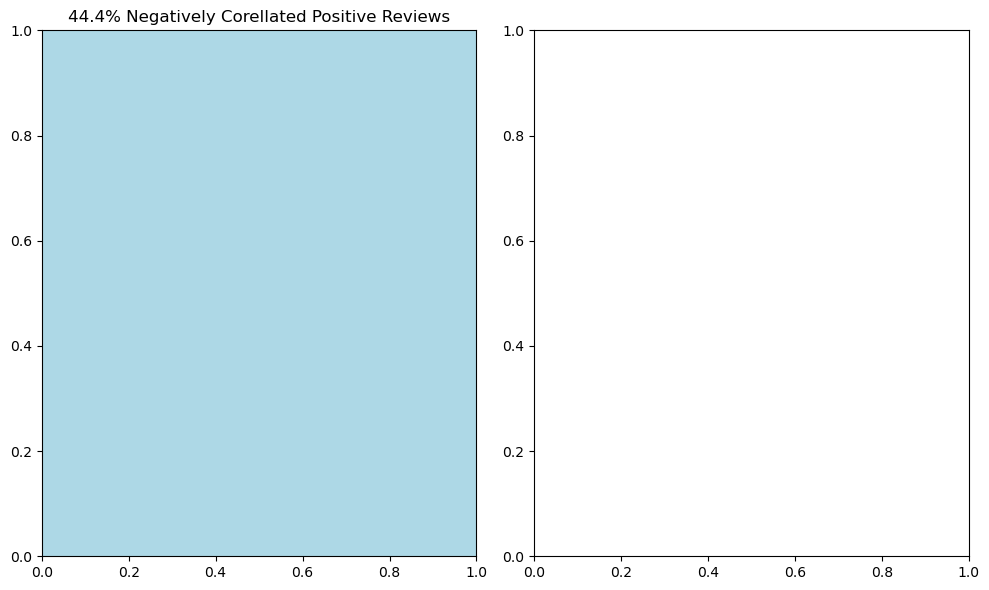

In [151]:
import statistics as stat
fig,axes = plt.subplots(1,2,figsize=(10,6),layout='tight')
#plt.subplot(121)
# Visualization for Top & Bottom 20 Predictive Words in a review considered "Negative"
#ax=plt.gca()

plt.subplot(121)
ax=axes[0]
axes[0].set_title('44.4% Negatively Corellated Positive Reviews')
palette = sns.diverging_palette(10,145,s=80,center="dark", n=40)
ax.set_facecolor('lightblue')
sns.histplot(Xtf_pos.coef,palette=palette,ax=axes[0],stat='density')
#ax = sns.histplot(Xtf_pos, kde=False, stat='density', label='samples')
axes[0].tick_params(rotation=-60)
#plt.axhline(y=0,color='maroon')
plt.axvline(x=0,color='red')
plt.axvline(x=0.22996,color='yellow')
plt.axvline(x=-0.22996,color='yellow')
axes[0].set_xlabel('Logistic Regression Coefficient')
axes[0].set_ylabel('Counts')
axes[0].set_ylim(0,3.75)
plt.ylabel('Log.Reg. Coefficients')


# Visualization for Top & Bottom 20 Predictive Words in a review considered "Negative"
#ax=plt.gca()
plt.subplot(122)
ax1=axes[1]
axes[1].set_title('41.1% Positively Corellated Negative Reviews')
sns.histplot(Xtf_neg.coef,palette=palette,ax=axes[1],stat='density')
palette = sns.diverging_palette(10,145,s=80,center="dark", n=40)
ax1.set_facecolor('lightblue')
sns.color_palette()
#ax.axhline(y=0,color='maroon')
ax1.axvline(x=0,color='red')
plt.axvline(x=0.22596,color='yellow')
plt.axvline(x=-0.22596,color='yellow')
axes[1].tick_params(labelrotation=-45)
axes[1].set_xlabel('Logistic Regression Coefficient')
axes[1].set_ylabel('Counts')
axes[1].set_ylim(0,3.75)

plt.suptitle('Distribution about in Positive (L) and Negative (R) Coefficient Distribution')
plt.show()
Xtc_Co['pos'].mean()

There is more insight to be gained from these visualizations that are presentable to a client, but that can be touched on later.

Train and test scores are pretty close! Both are capable of producing the right results about 78.8% of the time.<br>
This is in a unified model. With invidiual

### Word Count / Interpretations

## Question 4

In [ ]:
A little bit of relevant information:

In [ ]:
get_heatmap(pipe)

##### Evaluating for strong correlation between variables - there are several.
*- Total Number of Reviews ~ Additional Number of Scoring
*- Lat/Long ~ Hotel Locations
- Year ~ Days since Review`
Strong correlation between a number of features - all around a certain place, it would seem. 

Using a pipeline, combine PCA with a decision tree classifier.

Optimize at least 3 hyperparameters including the maximum tree depth and the minimum number of data points required on each leaf node.
You can use 20 principle components.
The best parameters should be found using 5-fold cross validation.

In [ ]:
import warnings
warnings.filterwarnings('ignore')


In [ ]:
Data=hotel.copy()
X= Data.drop(columns=['Reviewer_Score'])
y = Data['Reviewer_Score']

In [168]:
# load in data
Data=hotel.copy()
X = Data.drop(columns=['Positive_Review','Negative_Review'])
y = Data['Reviewer_Score']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

estimators = [('normalise', StandardScaler()),
              ('dimred', PCA()),
              ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators)

param_grid = [
            {
             'model': [DecisionTreeClassifier()],
             'model__max_depth': [2, 3, 4, 8],                #Hp1
             'model__min_samples_split': [1, 3, 6, 10],  #hp2
             'model__min_samples_leaf': [2, 4, 8],        #hp3
             'dimred__n_components': [3, 7, 13],  # Number of principal components #hp3.5
            }         
]
grid = GridSearchCV(pipe, param_grid, cv=5) # cross-validation
fittedgrid = grid.fit(X_train, y_train) 

In [171]:
export_graphviz

NameError: name 'export_graphviz' is not defined

In [177]:
#Fit the model (notice we've let the depth become unbounded)
model = DecisionTreeClassifier()
model.fit(X, y)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1,X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.001), np.arange(y_min, y_max, 0.1))

# Plotting decision regions
Z = DT_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, s=500,edgecolor='k')

#Need to add decision boundary in manually because of Python rendering issue.
plt.quiver([0,0],[-0.5,-0.5],[-1,1],[0,0],scale = 1,color='red')
plt.quiver([0.5],[-0.5],[0],[-1],scale = 1,color='red')
plt.quiver([0],[0.5],[1],[0],scale = 1,color='red')
plt.quiver([0],[-0.5],[0],[1],scale = 1,color='red')

plt.show()

InvalidIndexError: (slice(None, None, None), 0)

In [169]:
fittedgrid.cv_results_(ROUND1)

NameError: name 'ROUND1' is not defined

In [178]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0)
imputer = imputer.fit(X.iloc[:, 1:3])
X.iloc[:, 1:3] = imputer.transform(X.iloc[:, 1:3])

TypeError: SimpleImputer.__init__() got an unexpected keyword argument 'verbose'

In [163]:
fittedgrid.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('dimred', PCA(n_components=7)),
                ('model',
                 DecisionTreeClassifier(max_depth=4, min_samples_leaf=2))])

In [174]:
fittedgrid.best_params_

{'dimred__n_components': 13,
 'model': DecisionTreeClassifier(),
 'model__max_depth': 8,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 10}

In [175]:
fittedgrid.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('dimred', PCA(n_components=13)),
                ('model',
                 DecisionTreeClassifier(max_depth=8, min_samples_leaf=2,
                                        min_samples_split=10))])

In [179]:
fittedgrid.best_params_

{'dimred__n_components': 13,
 'model': DecisionTreeClassifier(),
 'model__max_depth': 8,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 10}

In [176]:
fittedgrid.best_params_

{'dimred__n_components': 13,
 'model': DecisionTreeClassifier(),
 'model__max_depth': 8,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 10}

In [164]:
fittedgrid.best_params_

{'dimred__n_components': 7,
 'model': DecisionTreeClassifier(),
 'model__max_depth': 4,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 2}

In [161]:
fittedgrid.best_params_

{'dimred__n_components': 7,
 'model': DecisionTreeClassifier(),
 'model__max_depth': 4,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 2}

In [183]:
fittedgrid.best_params_

{'dimred__n_components': 13,
 'model': DecisionTreeClassifier(),
 'model__max_depth': 8,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 10}

In [182]:
fittedgrid.best_estimator_
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

[Text(0.5, 0.75, 'Reviewer_Score <= 0.5\ngini = 0.49\nsamples = 515199\nvalue = [221484, 293715]\nclass = Yes'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 221484\nvalue = [221484, 0]\nclass = No'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 293715\nvalue = [0, 293715]\nclass = Yes'),
 Text(0.625, 0.5, '  False')]

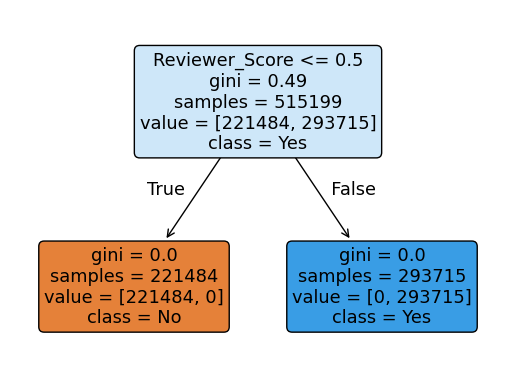

In [181]:
 from sklearn.tree import plot_tree

# Assuming 'clf' is your decision tree model
plot_tree(model, filled=True, rounded=True, class_names=['No', 'Yes'], feature_names=X.columns)

[Text(0.5, 0.75, 'Reviewer_Score <= 0.5\ngini = 0.49\nsamples = 515199\nvalue = [221484, 293715]\nclass = Yes'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 221484\nvalue = [221484, 0]\nclass = No'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 293715\nvalue = [0, 293715]\nclass = Yes'),
 Text(0.625, 0.5, '  False')]

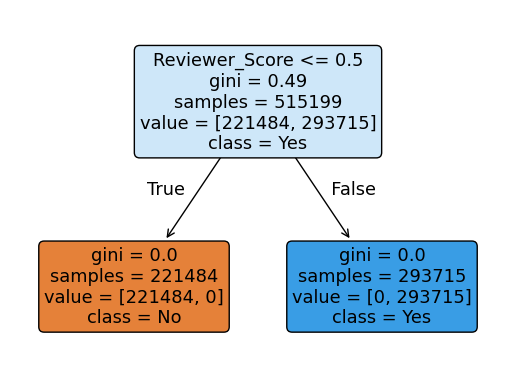

In [180]:
plot_tree(model, filled=True, rounded=True, class_names=['No', 'Yes'], feature_names=X.columns)

In [184]:
#Fit the model (notice we've let the depth become unbounded)
dts = DecisionTreeClassifier()
DT_model.fit(X, y)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1,X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.001), np.arange(y_min, y_max, 0.1))

# Plotting decision regions
Z = DT_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, s=500,edgecolor='k')

#Need to add decision boundary in manually because of Python rendering issue.
plt.quiver([0,0],[-0.5,-0.5],[-1,1],[0,0],scale = 1,color='red')
plt.quiver([0.5],[-0.5],[0],[-1],scale = 1,color='red')
plt.quiver([0],[0.5],[1],[0],scale = 1,color='red')
plt.quiver([0],[-0.5],[0],[1],scale = 1,color='red')

plt.show()

InvalidIndexError: (slice(None, None, None), 0)

In [ ]:
# A loop to test various C-values to 


C_values = [0.001, 0.01, 0.1, 1, 10, 100]
#Loop for C values
for C in C_values:
    #fit
    pos_log_reg_C = LogisticRegression(max_iter=500,C=C,penalty='l1',solver='saga')
    pos_log_reg_C.fit(pos_X_train, y_train)
    # Evaluate the model on the test set
    train_score= pos_log_reg_C.score(pos_X_train, y_train)
    test_score = pos_log_reg_C.score(pos_X_test, y_test)
    scorecard.loc[scorecard.shape[0],:]=['Logistic','Standard',pos_train_score,pos_test_score,'pos',C,'l1','saga']

In [ ]:
PlotBoundaries(LR_model, X_train, y_train) 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Fitting the linear model
LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)

# Visualize its results
PlotBoundaries(LR_model, X_train, y_train) 

# Evaluate its classification accuracy (Just on the training set for now)
print(f"Train set accuracy: {LR_model.score(X_train, y_train)}")

## Question 5

##### Part 0: Gibberish Insight for later, if any reason

In [ ]:
# Plot out the cumulative sum graph

plt.figure()
plt.plot(range(1,100), cum_sum[:99], marker='.')
plt.axhline(0.9, c='r', linestyle='--')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Sum of Explained Variance')
plt.xticks(range(1,21,2))
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import load_breast_cancer

estimators = [('normalise', StandardScaler()),
              ('reduce_dim', PCA()),
              ('logreg', LogisticRegression())]
pipe = Pipeline(estimators)

In [ ]:


## VERY SPECIFIC: TWO UNDERSCORES BETWEEN ESTIMATOR NAME [AND] NAME OF THAT PARAMETER
params = {'logreg__C': [0.001, 0.1, 1, 100], 
          'reduce_dim__n_components': [1, 2, 3]}

grid_search = GridSearchCV(pipe, param_grid=params)

#### Pipeline

In [ ]:
explained_variance = PCA.explained_variance_ratio_.cumsum()

plt.figure(figsize=(10, 7))
plt.plot(range(1,14), explained_variance)
plt.scatter(range(1,14), explained_variance)
plt.title("Cumulative explained variance ratio")
plt.xlabel("Number of Components")
plt.ylabel("Variance explained (ratio)")
plt.show()

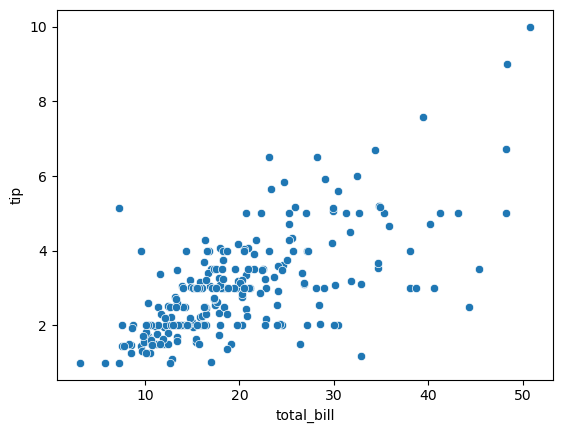

In [28]:
# Sample Data
tips = sns.load_dataset("tips")

# Create a simple scatterplot
sns.scatterplot(x="total_bill", y="tip", data=tips)
plt.show()

In [29]:
plt.figure()
plt.plot(range(1,21),expl_var[:20],marker='.')
plt.xlabel('Number of PCs')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(1,21,1))
plt.show()

NameError: name 'expl_var' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
df = pd.DataFrame({
    'PC1': transformed_data[:, 0], 'PC2': transformed_data[:, 1]})


sns.scatterplot(x='PC1', y='PC2', data=df)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PC2 Projected on PC1')
plt.show()

In [ ]:
y=hotel.Reviewer_Score

In [ ]:
X=pipe

In [ ]:
X1_train,X_test,y1_train, y_test = train_test_split(X, y, test_size=0.20, random_state=20)
X_train, VX_test, y_train, Vy_test = train_test_split(X1_train,y1_train, test_size=0.1, random_state=117)

In [ ]:
## Review of avaialble basic df for use
# hotel - full set with dummies
# hotel_pos - positive reviews with dummies
# hotel_neg - negative reviews with dummies
# hotel_nd - full no dummies
# hotel_nd_nreviews - no dummies no reviews

In [ ]:
import string
import re

In [ ]:
hotel.Positive_Review.str.split(pat=' ').apply(len).describe()

In [ ]:
hotel.Review_Total_Positive_Word_Counts.describe()

In [ ]:
hotel.Negative_Review.str.split(pat=' ').apply(len).describe()

In [ ]:
hotel.Review_Total_Negative_Word_Counts.describe()

In [ ]:
### Values seem to match up for the most part. Off by a fraction of a word here or there.

In [ ]:
hotel_pos=hotel[hotel.Reviewer_Score==1]
hotel_neg=hotel[hotel.Reviewer_Score==0]

In [ ]:
# Taking a subsample of 20% to test
hotel_sub=hotel.sample(frac=0.2)

##### Part 0b, roll it up there~ish: Fx, cleaning proc., review

In [ ]:
hotel[hotel.columns[24:28]].sum()/hotel[hotel.columns[24:29]].sum().sum()

In [ ]:
hotel['Hotel_Address_Other']=pd.merge([hotel['Hotel_Address_Vienna'],hotel['Hotel_Address_Milan']])
hotel_df=hotel.drop(columns=['Hotel_Address_Milan','Hotel_Address_Vienna'])
hotel_df

In [ ]:
X_train_tb20=pd.concat([X_train[Xtf_Co.feat2.head(20)],X_train[Xtf_Co.feat2.tail(20)]],axis=1).fillna('0').astype(dtype=int)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Sample text data
X_train

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the data
X = vectorizer.fit_transform(X_train)

# Print the resulting TF-IDF matrix
print(X.toarray())

In [ ]:
import 

In [ ]:
test_neg=pd.DataFrame()

In [ ]:
test_neg['coef']=neg_coef
test_neg['names']=neg_coef_names

In [ ]:
test_neg.sort_values(by='coef',ascending=False)

In [ ]:
neg_words.sort_values(ascending=False)

In [ ]:
print('df:',sys.getsizeof(test_neg))
print('s:',sys.getsizeof(neg_words))

In [ ]:
X_final_reversed.info()

In [ ]:
X_final_reversed.index

In [ ]:
test_neg.iloc[1]

In [ ]:
X_train_

In [ ]:
x_final_coef['coef']=log_reg.coef_

In [ ]:
X_train_reversed

In [ ]:
sys.getsizeof(X_train)

In [ ]:
print(X_train.info())
X_train.index

In [ ]:
print(X_final_reversed.info())
X_final_reversed.index

len(hotel_neg[hotel_neg.Positive_Review=='No Positive'])

In [ ]:
hotel.groupby(['Additional_Number_of_Scoring','Total_Number_of_Reviews','Average_Score']).Nights_Stayed.mean()

In [ ]:
hotel['Positive_Review',

In [ ]:
len(hotel_neg[hotel_neg.Negative_Review=='No Negative'])

In [ ]:
len(hotel_pos[hotel_pos.Positive_Review=='No Positive'])

In [ ]:
hotel_neg[hotel_neg.Negative_Review=='No Negative']

## DATA DICTIONARY

In [ ]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
#Create a loop to test different C values
for C in C_values:
    #fit
    neg_log_reg_C = LogisticRegression(max_iter=500,C=C,penalty='l2')
    neg_log_reg_C.fit(neg_X_train, y_train)
    # Evaluate the model on the test set
    train_score= neg_log_reg_C.score(neg_X_train, y_train)
    test_score = neg_log_reg_C.score(neg_X_test, y_test)
    scorecard.loc[scorecard.shape[0],:]=['Logistic','Standard',neg_train_score,neg_test_score,'neg',C,'l1','saga']

In [ ]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
#Create a loop to test different C values
for C1 in C_values:
    #fit
    X_log_reg_C = LogisticRegression(max_iter=500,C=C1,penalty='l1',solver='saga')
    X_log_reg_C.fit(X_train_ss, y_train)
    # Evaluate the model on the test set
    train_score= X_log_reg_C.score(X_train_ss, y_train)
    test_score = X_log_reg_C.score(X_test_ss, y_test)
    scorecard.loc[scorecard.shape[0],:]=['Logistic','Standard',X_pos_train_score,X_test_score,'X',C,'l2','saga']

In [ ]:
# Create a sample DataFrame
data = {
    'type': [],
    'dummy':[],
    'notes':[],
    'dropped':[]
}
    
#}
df = pd.DataFrame(data)
data_dictionary = pd.DataFrame(index=df.columns, columns=hotel.columns)
# Create a data dictionary


In [ ]:
data_dictionary

In [ ]:
hotel.head(1)

In [ ]:
data_dictionary

In [ ]:
is_na=[]
dtype=[]
duplicated=[]

# Establishing columns as needed
for col in hotel.columns:
    data_dictionary[col].type=hotel[col].dtype
    print(hotel[col].dtype)

In [ ]:
hotel['Average_Score'].isna().value_counts()

In [ ]:
data_dictionary=data_dictionary.T

In [ ]:
data_dictionary

In [ ]:
lazy_info(data_dictionary)

In [ ]:
#Assign dummy columns
   #data_dictionary.iloc[17:,].dummy.fillna(1,inplace=True)
   #data_dictionary.iloc[:17].dummy.fillna(0,inplace=True)

In [ ]:
#Assign dropped values 
   #data_dictionary.dropped.fillna(0,inplace=True)

In [1]:
#Get rid of NaN notes
data_dictionary.notes.fillna('null',inplace=True)

NameError: name 'data_dictionary' is not defined